In [30]:
import numpy as np
import pandas as pd
import pytest
from anndata import AnnData
from glm_toolkit.estimators import negbin_regression
from glm_toolkit.predictors import negbin_predict
from glm_toolkit.samplers import negbin_sample

In [31]:
def sample_data(n_samples=1000, n_features=3, n_genes=5):
    """Create sample data for testing"""
    np.random.seed(42)
    
    # Create feature matrix
    X = np.random.normal(0, 1, (n_samples, n_features))
    obs = pd.DataFrame(X, columns=[f'feature_{i}' for i in range(n_features)])
    
    # Create true parameters
    true_beta = np.random.normal(0, 1, (n_features, n_genes))
    true_gamma = np.exp(np.random.normal(0, 0.1, n_genes))
    
    # Generate response
    mu = np.exp(X @ true_beta)
    Y = np.zeros((n_samples, n_genes))
    for i in range(n_genes):
        Y[:, i] = np.random.negative_binomial(n=true_gamma[i], p=true_gamma[i]/(true_gamma[i] + mu[:, i]))
    
    # Create AnnData object
    adata = AnnData(X=Y, obs=obs, var=pd.DataFrame(index=[f'gene_{i}' for i in range(n_genes)]))
    
    return {
        'adata': adata,
        'true_beta': true_beta,
        'true_gamma': true_gamma
    }
    
def test_negbin_regression(sample_data):
    """Test negative binomial regression estimation"""
    adata = sample_data['adata']
    formula = "feature_0 + feature_1 + feature_2"
    
    # Fit model
    params = negbin_regression(adata, formula)
    
    # Check parameter shapes
    print(params['beta'].shape, params['gamma'].shape)
    assert params['beta'].shape == (4, 5)  # 4 features (intercept + 3 features), 5 genes
    assert params['gamma'].shape == (1, 5)  # dispersion parameter for each gene
    
    # Check parameter values are reasonable
    assert np.all(np.isfinite(params['beta']))
    assert np.all(params['gamma'] > 0)  # dispersion should be positive

def test_negbin_predict(sample_data):
    """Test negative binomial prediction"""
    adata = sample_data['adata']
    formula = "feature_0 + feature_1 + feature_2"
    
    # Fit model and predict
    params = negbin_regression(adata, formula)
    predictions = negbin_predict(params, adata.obs, formula)['mean']
    
    # Check predictions
    assert predictions.shape == adata.X.shape
    assert np.all(predictions >= 0)  # predictions should be non-negative
    assert np.all(np.isfinite(predictions))

def test_negbin_sample(sample_data):
    """Test negative binomial sampling"""
    adata = sample_data['adata']
    formula = "feature_0 + feature_1 + feature_2"
    
    # Fit model and sample
    params = negbin_regression(adata, formula)
    print(params)
    local_params = negbin_predict(params, adata.obs, formula)
    samples = negbin_sample(local_params, adata.obs)
    
    # Check samples
    assert samples.shape == adata.X.shape
    assert np.all(samples.X >= 0)  # samples should be non-negative integers
    assert np.all(np.isfinite(samples.X))
    assert np.all(samples.X.astype(int) == samples.X)  # should be integers 

In [28]:
data = sample_data()
test_negbin_regression(data)
test_negbin_predict(data)
test_negbin_sample(data)

/opt/miniconda3/envs/scdesign/lib/python3.12/site-packages/anndata/_core/aligned_df.py:68: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)


(4, 5) (1, 5)


{'beta':              gene_0    gene_1    gene_2    gene_3    gene_4
Intercept  0.177979  0.005448  0.103310  0.840072  0.032775
feature_0 -1.593129 -0.797033 -0.410262  1.420106  0.520759
feature_1 -1.259142  0.613093 -1.445544  1.153846 -0.426870
feature_2 -0.076834  1.282099 -1.262576 -1.203835 -0.646689, 'gamma':               gene_0   gene_1    gene_2    gene_3    gene_4
dispersion  0.680569  1.00905  0.731384  0.411762  0.936496}


In [35]:
example = sample_data(n_samples = 1000)
adata = example['adata']
formula = "feature_0 + feature_1 + feature_2 - 1"

# Fit model
params = negbin_regression(adata, formula)
local_params = negbin_predict(params, adata.obs, formula)
samples = negbin_sample(local_params, adata.obs)

display(params['beta'])
display(params['gamma'])

display(example['true_beta'])
display(example['true_gamma'])

/opt/miniconda3/envs/scdesign/lib/python3.12/site-packages/anndata/_core/aligned_df.py:68: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)


,gene_0,gene_1,gene_2,gene_3,gene_4
feature_0,-1.816358,-0.789964,-0.436984,1.708358,0.526199
feature_1,-1.428152,0.623744,-1.634186,1.250548,-0.418931
feature_2,-0.108495,1.240821,-1.383527,-1.374376,-0.662250


,gene_0,gene_1,gene_2,gene_3,gene_4
dispersion,0.743235,0.991726,0.771422,0.41236,0.936777


array([[-1.90780756, -0.86038501, -0.41360553,  1.88768766,  0.55655312],
       [-1.33548157,  0.48603629, -1.54730399,  1.08269105, -0.47112465],
       [-0.09363619,  1.32579665, -1.28716357, -1.39711819, -0.58359933]])

array([1.10942059, 0.85904445, 0.75335738, 0.9558867 , 1.05672455])

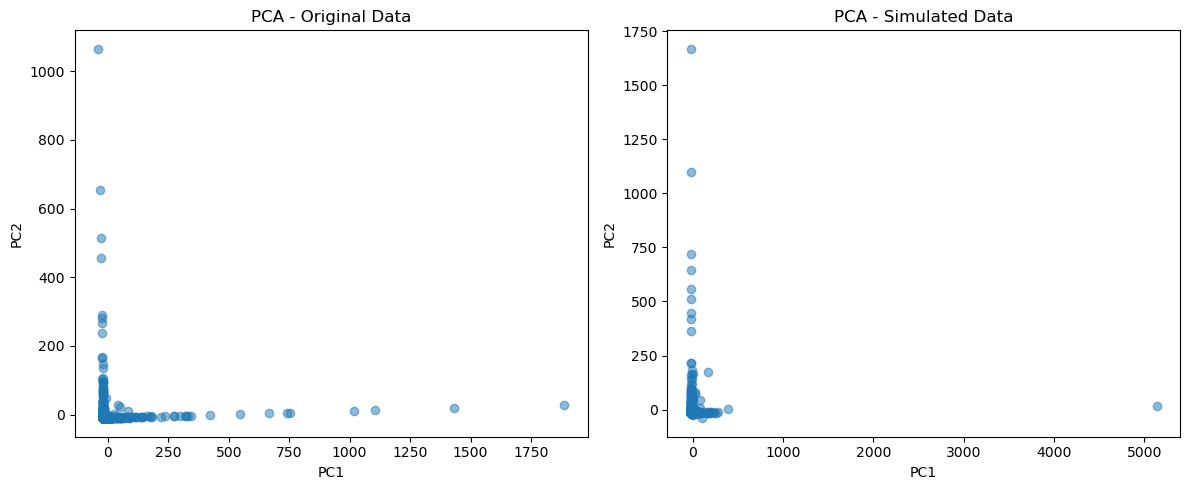

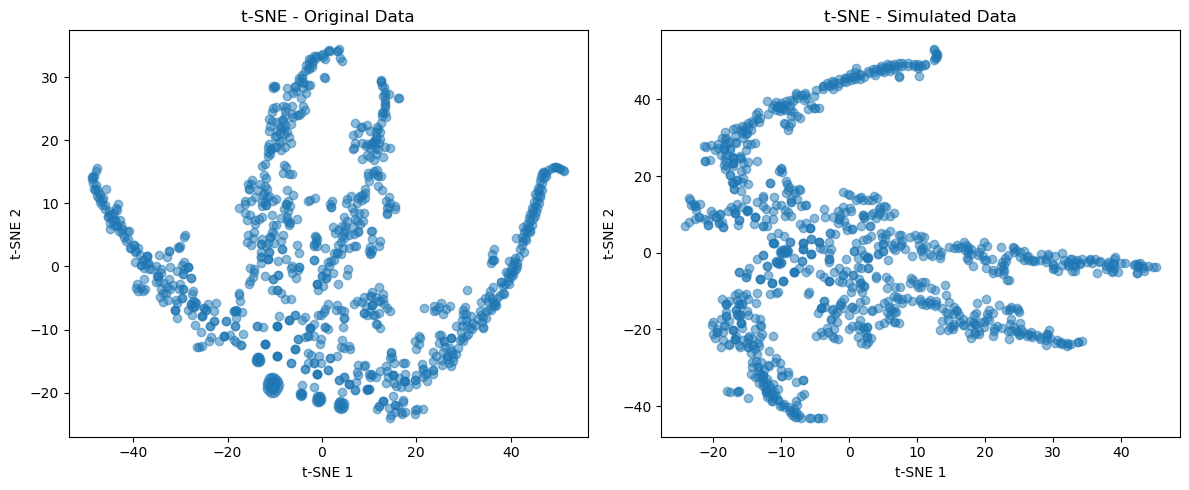

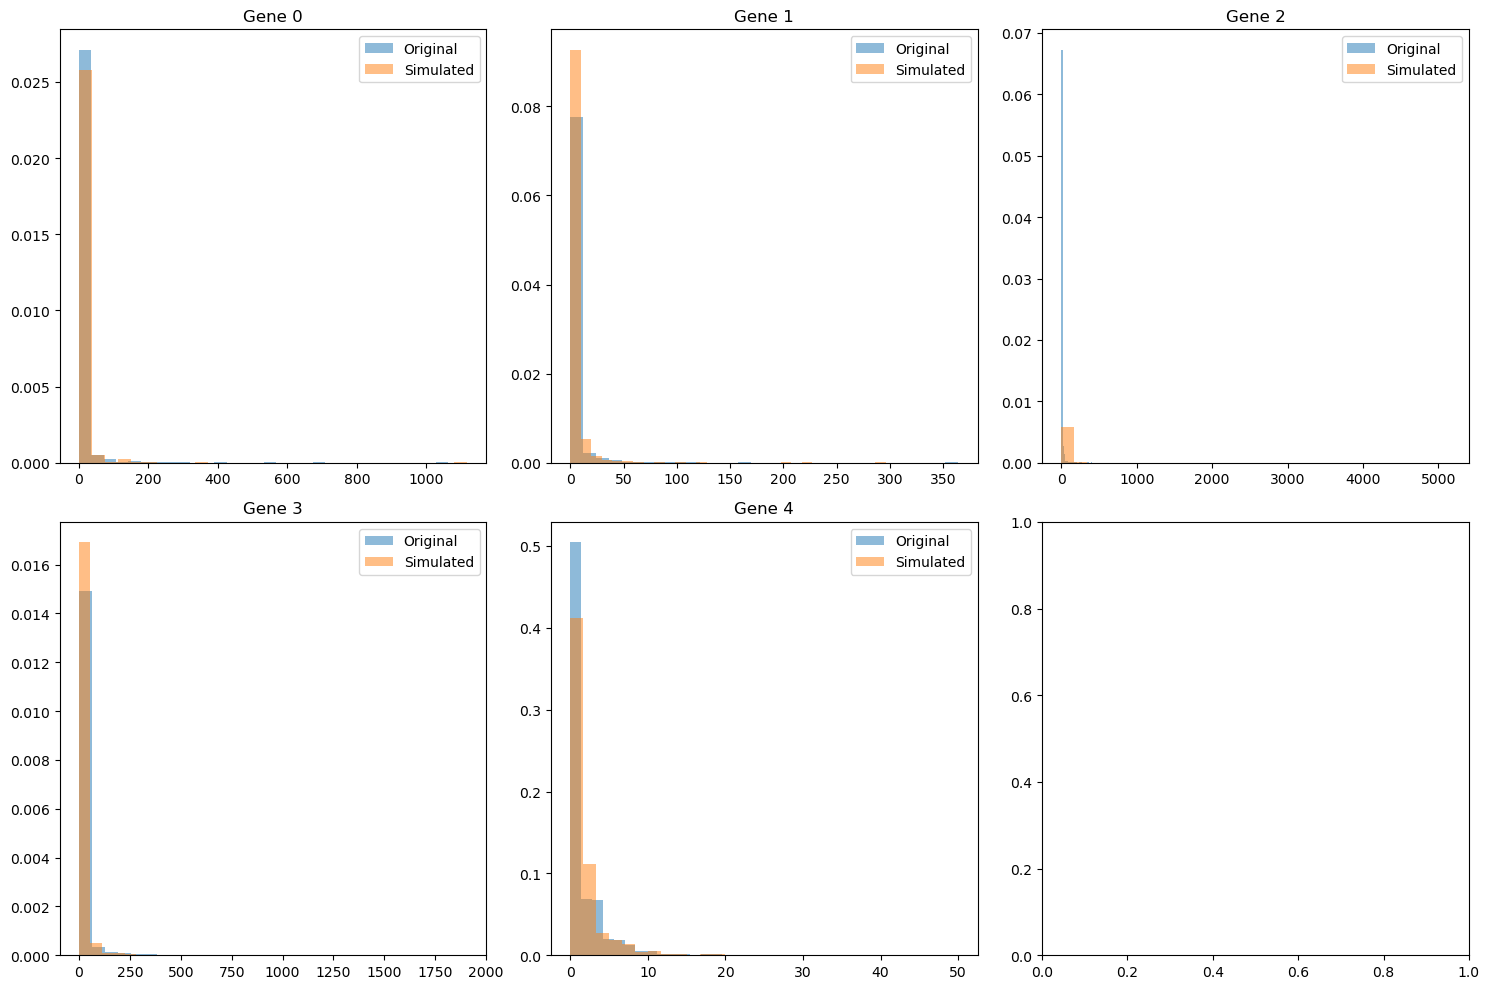

In [37]:
# Perform dimensionality reduction and visualization
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
import pandas as pd

# Function to perform dimensionality reduction
def reduce_dimensions(data, method='both'):
    # PCA
    pca = PCA(n_components=2)
    pca_result = pca.fit_transform(data)
    
    # t-SNE
    tsne = TSNE(n_components=2, random_state=42)
    tsne_result = tsne.fit_transform(data)
    
    return pca_result, tsne_result

# Get PCA and t-SNE results for both original and simulated data
pca_orig, tsne_orig = reduce_dimensions(adata.X)
pca_sim, tsne_sim = reduce_dimensions(samples.X)

# Create figure for PCA comparison
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))

# Plot PCA results
ax1.scatter(pca_orig[:, 0], pca_orig[:, 1], alpha=0.5, label='Original')
ax1.set_title('PCA - Original Data')
ax1.set_xlabel('PC1')
ax1.set_ylabel('PC2')

ax2.scatter(pca_sim[:, 0], pca_sim[:, 1], alpha=0.5, label='Simulated')
ax2.set_title('PCA - Simulated Data')
ax2.set_xlabel('PC1')
ax2.set_ylabel('PC2')

plt.tight_layout()
plt.show()

# Create figure for t-SNE comparison
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))

# Plot t-SNE results
ax1.scatter(tsne_orig[:, 0], tsne_orig[:, 1], alpha=0.5, label='Original')
ax1.set_title('t-SNE - Original Data')
ax1.set_xlabel('t-SNE 1')
ax1.set_ylabel('t-SNE 2')

ax2.scatter(tsne_sim[:, 0], tsne_sim[:, 1], alpha=0.5, label='Simulated')
ax2.set_title('t-SNE - Simulated Data')
ax2.set_xlabel('t-SNE 1')
ax2.set_ylabel('t-SNE 2')

plt.tight_layout()
plt.show()

# Additionally, show original distribution comparisons
fig, axes = plt.subplots(2, 3, figsize=(15, 10))
axes = axes.flatten()

# Plot histograms for first 5 genes
for i in range(min(5, adata.X.shape[1])):
    axes[i].hist(adata.X[:, i], bins=30, alpha=0.5, label='Original', density=True)
    axes[i].hist(samples.X[:, i], bins=30, alpha=0.5, label='Simulated', density=True)
    axes[i].set_title(f'Gene {i}')
    axes[i].legend()

plt.tight_layout()
plt.show()